# My first project:

## Steps
 - Includes setting up jupyter notebooks
 - Setting up postgresql
 - Dowloading and uploading the sample dvd rental database to postgresql
 - dowloading the psycopg2 package for enabling connection to a db'

First step involves importing the pandas library and psycopg2

In [1]:
import pandas as pd
import psycopg2
%matplotlib inline 
import matplotlib.pyplot as plt

First we connect to the Postgresql DB. We will be working with the sample_db.
It contains data relating to a movie rental service

In [2]:
conn = psycopg2.connect( "host=localhost user=postgres password=andru3000 dbname=sample_db")

First query to test the connnection. Selecting five actors ordered by their first name

In [49]:
q = "select actor_id,first_name,last_name from actor order by first_name limit 5"
pd.read_sql_query(q,conn)

,actor_id,first_name,last_name
0,132,Adam,Hopper
1,71,Adam,Grant
2,165,Al,Garland
3,173,Alan,Dreyfuss
4,125,Albert,Nolte


R rated movies in alphabetical order

In [54]:
q2 = "select title,rating from film where rating = 'R'order by title asc limit 5"
pd.read_sql_query(q2,conn)

,title,rating
0,Airport Pollock,R
1,Alone Trip,R
2,Amelie Hellfighters,R
3,American Circus,R
4,Anaconda Confessions,R


Top customers who have spent above average spend renting movies

<BarContainer object of 10 artists>

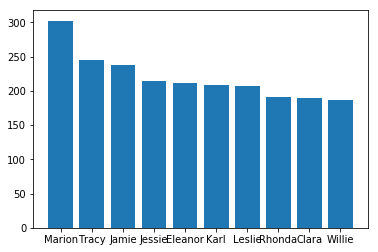

In [60]:
q3 = """with value_cust as (
                  select first_name,sum(amount)as cust_value
                  from customer c
                  join payment p
                  on c.customer_id = p.customer_id
                  group by first_name
                  order by cust_value desc)

                  select first_name,cust_value
                  from value_cust v
                  where v.cust_value >(select round (avg(cust_value),3)from value_cust)
                  limit 10"""
ft = pd.read_sql_query(q3,conn)
plt.bar(ft.first_name,ft.cust_value)

Top staff by sales

,first_name,last_name,perc_sales
0,Jon,Stephens,51.0
1,Mike,Hillyer,49.0


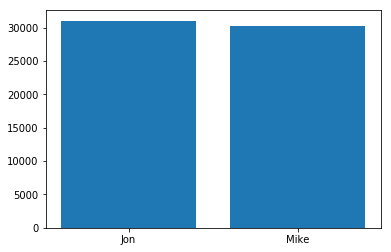

In [67]:
q4 = """select s.first_name,s.last_name,sum(p.amount) total_sales
        from staff s
        join payment p
        on s.staff_id = p.staff_id
        group by s.first_name,s.last_name
        order by total_sales desc"""
ft2 = pd.read_sql_query(q4,conn)
plt.bar(ft2.first_name,ft2.total_sales)
ft2
q5 = """with sales_per_staff as(
              select s.first_name,s.last_name,sum(p.amount) total_sales
             from staff s
             join payment p
             on s.staff_id = p.staff_id
             group by s.first_name,s.last_name
             order by total_sales desc)

             select s.first_name,s.last_name,
             Round(total_sales/(select sum(total_sales) from sales_per_staff),2)*100 Perc_sales
             from sales_per_staff as s """
ft3 = pd.read_sql_query(q5,conn)
ft3

Movies each staff rented out per category

In [68]:
q6 = """with sold_movie as (
select s.first_name,r.rental_id,f.title,f.rating
from staff s
join payment p on s.staff_id = p.staff_id
join rental r on p.rental_id = r.rental_id
join inventory i on r.inventory_id = i.inventory_id
join film f on i.film_id = f.film_id)

select first_name,
       sum(case when rating = 'R'then 1 else 0 end) R_sold,
	   sum(case when rating = 'G' then 1 else 0 end) G_sold,
	   sum(case when rating = 'PG-13' then 1 else 0 end) PG13_sold,
	   sum(case when rating = 'NC-17' then 1 else 0 end) NC17_sold,
	   sum(case when rating = 'PG' then 1 else 0 end) PG_sold
from sold_movie
group by first_name"""
pd.read_sql_query(q6,conn)

,first_name,r_sold,g_sold,pg13_sold,nc17_sold,pg_sold
0,Mike,1499,1234,1578,1507,1474
1,Jon,1398,1274,1667,1501,1464


Movie rentals by category

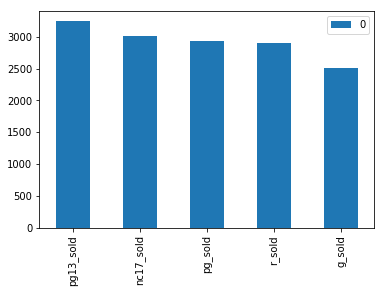

In [11]:
q7 = """with sold_movie as (
select s.first_name,r.rental_id,f.title,f.rating
from staff s
join payment p on s.staff_id = p.staff_id
join rental r on p.rental_id = r.rental_id
join inventory i on r.inventory_id = i.inventory_id
join film f on i.film_id = f.film_id)


select sum(case when rating = 'PG-13' then 1 else 0 end) PG13_sold,
	   sum(case when rating = 'NC-17' then 1 else 0 end) NC17_sold,
       sum(case when rating = 'PG' then 1 else 0 end) PG_sold,
       sum(case when rating = 'R'then 1 else 0 end) R_sold,
	   sum(case when rating = 'G' then 1 else 0 end) G_sold       
from sold_movie"""
ft4 = pd.read_sql_query(q7,conn)
ft4 = pd.DataFrame(ft4).T
ft4.plot(kind = 'bar')

Time series of payments

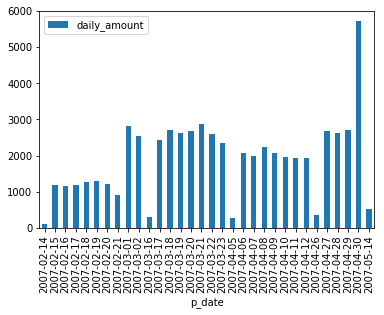

In [9]:
q8 = """ select cast(payment_date as date) p_date,sum(amount) daily_amount
         from payment
         group by p_date
         order by p_date asc """
pd.read_sql_query(q8,conn)
ft5 = pd.read_sql_query(q8,conn)
ts = ft5.set_index('p_date')
ts.plot(kind = 'bar')